# tradeSeq

In [3]:
if(!requireNamespace("BiocManager", quietly = TRUE)) {
 install.packages("BiocManager") 
}
BiocManager::install("tradeSeq")

library(devtools)
install_github("epurdom/clusterExperiment")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.23), R 4.2.3 (2023-03-15)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'tradeSeq'”
Old packages: 'KernSmooth', 'Seurat', 'SeuratObject', 'broom', 'dqrng'



In [ ]:
library(tradeSeq)
library(RColorBrewer)
library(SingleCellExperiment)
library(slingshot)

# For reproducibility
RNGversion("3.5.0")
palette(brewer.pal(8, "Dark2"))
data(countMatrix, package = "tradeSeq")
counts <- as.matrix(countMatrix)
rm(countMatrix)
data(crv, package = "tradeSeq")
data(celltype, package = "tradeSeq")

In [ ]:
'''
counts: gene x cell
celltype: cell x 1
crv: 
'''


In [11]:
crv

class: SlingshotDataSet 

 Samples Dimensions
    2660          2

lineages: 2 
Lineage1: 1  4  3  7  5  
Lineage2: 1  2  6  

curves: 2 
Curve1: Length: 1.1152	Samples: 1624.42
Curve2: Length: 0.91389	Samples: 1234.04

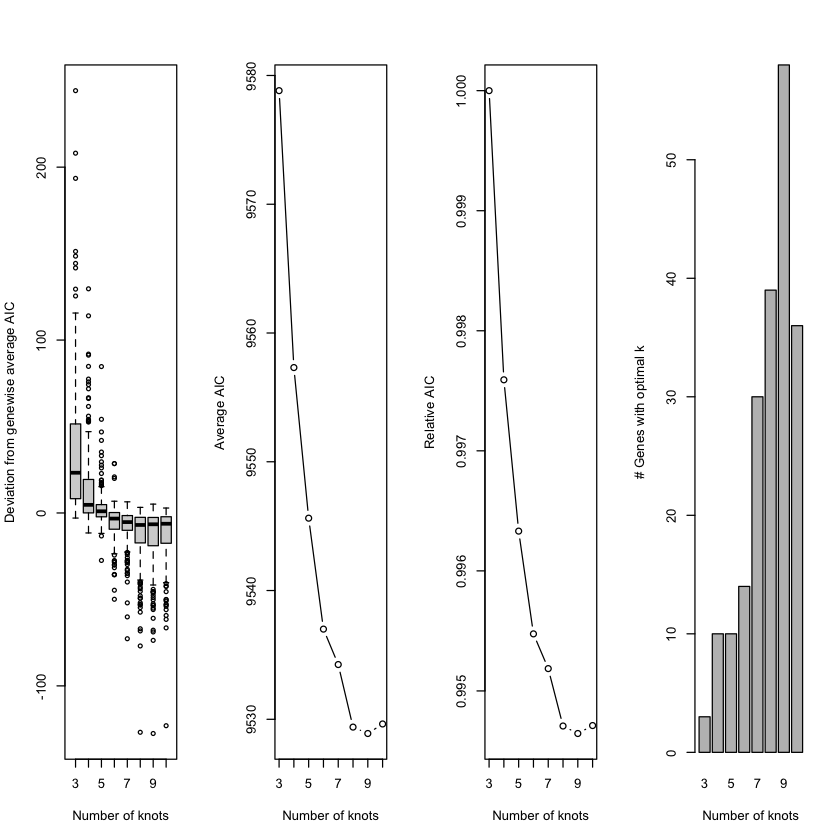

In [5]:
set.seed(5)
icMat <- evaluateK(counts = counts, sds = crv, k = 3:10, 
                   nGenes = 200, verbose = T)

In [6]:
set.seed(7)
pseudotime <- slingPseudotime(crv, na = FALSE)
cellWeights <- slingCurveWeights(crv)
sce <- fitGAM(counts = counts, pseudotime = pseudotime, cellWeights = cellWeights,
                 nknots = 6, verbose = FALSE)

In [7]:
table(rowData(sce)$tradeSeq$converged)


TRUE 
 240 

In [8]:
assoRes <- associationTest(sce)
head(assoRes)

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
Acin1,NA,NA,NA,0.3155838
Actb,NA,NA,NA,0.5610723
Ak2,NA,NA,NA,0.7030388
Alad,NA,NA,NA,1.0476606
Alas1,NA,NA,NA,1.1210974
Aldoa,199.2474,10,0,0.4340672


In [9]:
startRes <- startVsEndTest(sce)

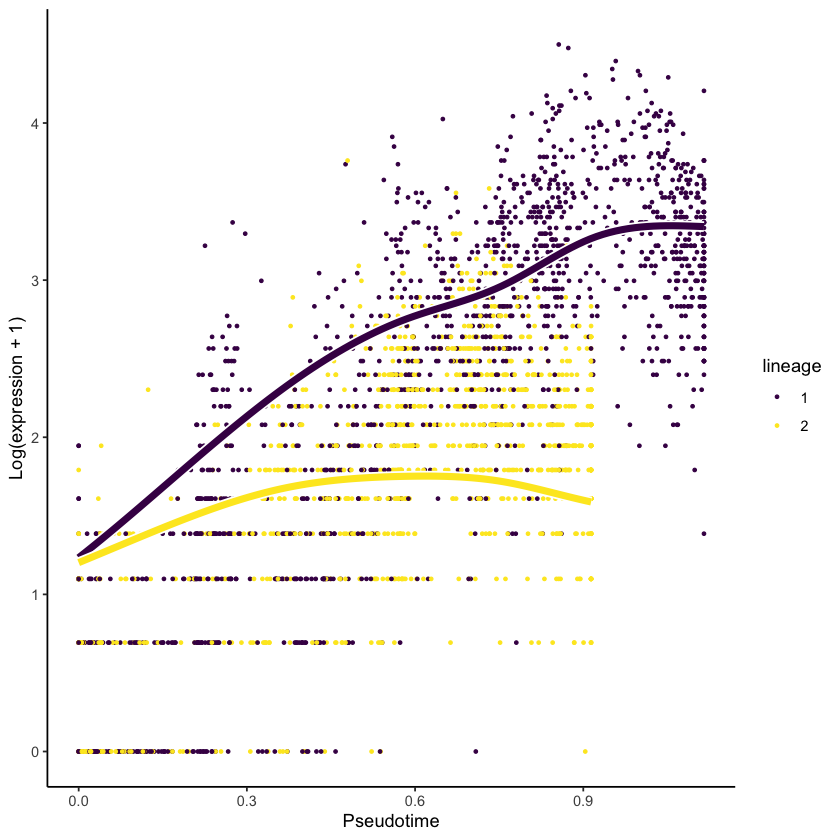

In [10]:
oStart <- order(startRes$waldStat, decreasing = TRUE)
sigGeneStart <- names(sce)[oStart[3]]
plotSmoothers(sce, counts, gene = sigGeneStart)

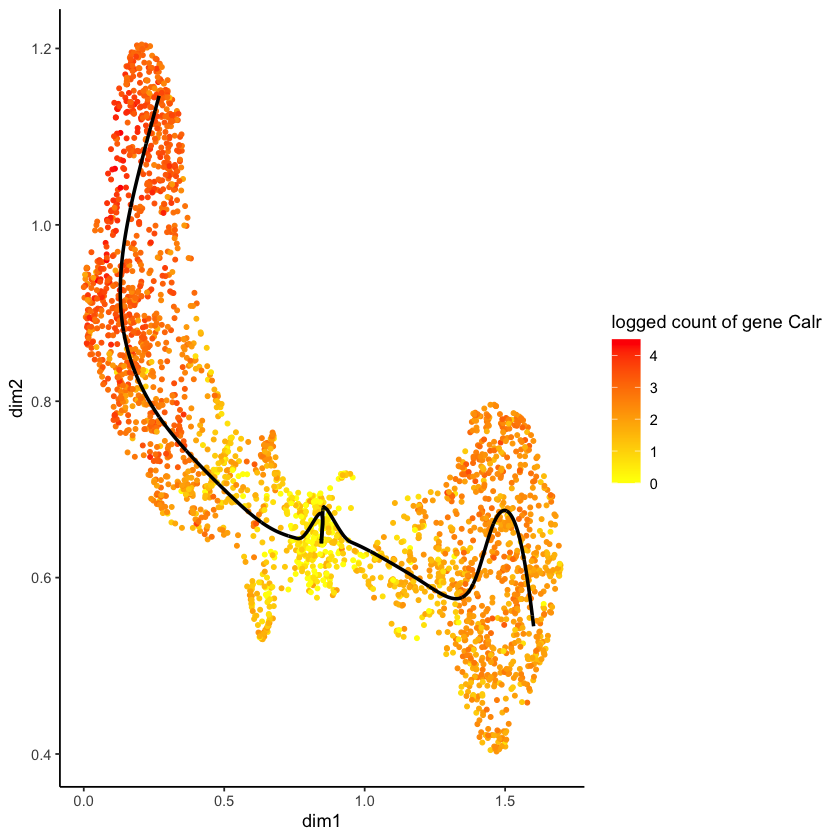

In [11]:
plotGeneCount(crv, counts, gene = sigGeneStart)

In [12]:
customRes <- startVsEndTest(sce, pseudotimeValues = c(0.1, 0.8))

In [13]:
endRes <- diffEndTest(sce)

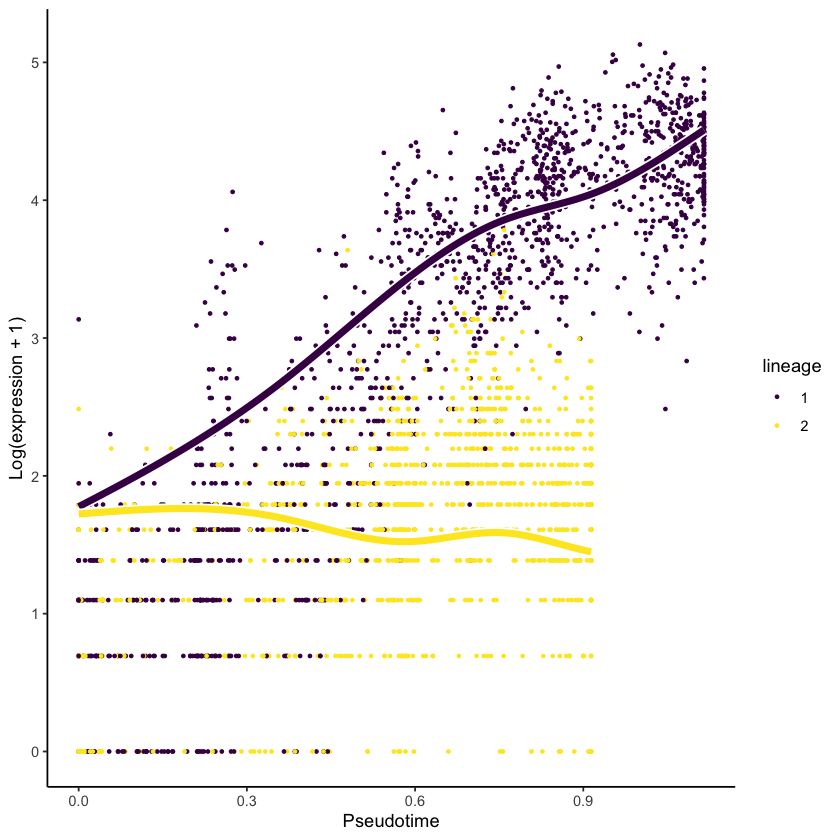

In [14]:
o <- order(endRes$waldStat, decreasing = TRUE)
sigGene <- names(sce)[o[1]]
plotSmoothers(sce, counts, sigGene)

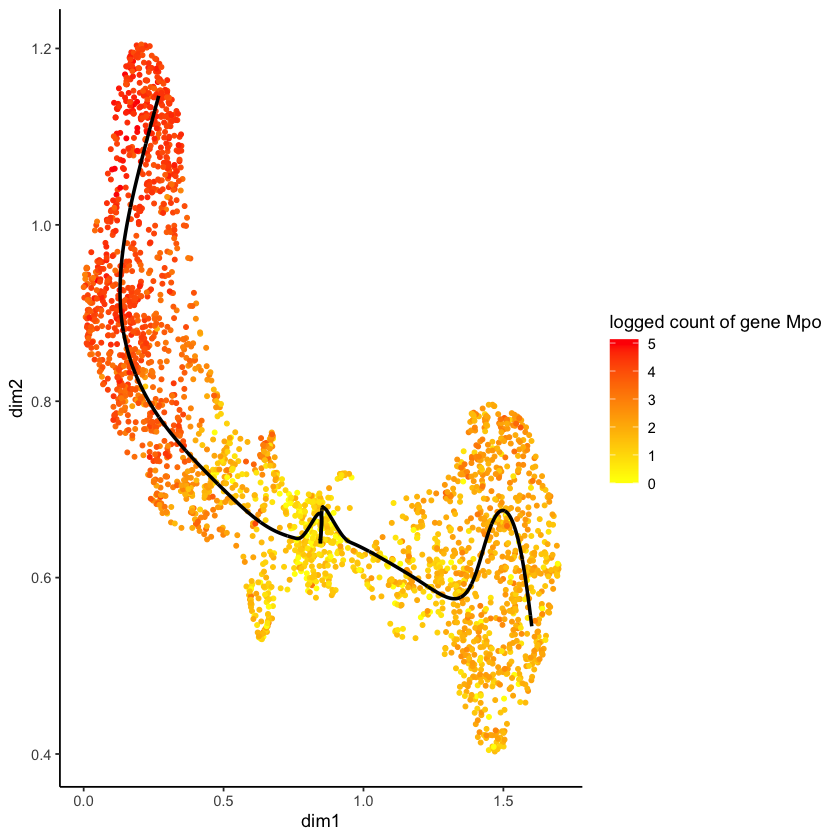

In [15]:
plotGeneCount(crv, counts, gene = sigGene)

In [16]:
patternRes <- patternTest(sce)
oPat <- order(patternRes$waldStat, decreasing = TRUE)
head(rownames(patternRes)[oPat])

[1] "Mpo"   "Prtn3" "Car2"  "Ctsg"  "Elane" "Calr"

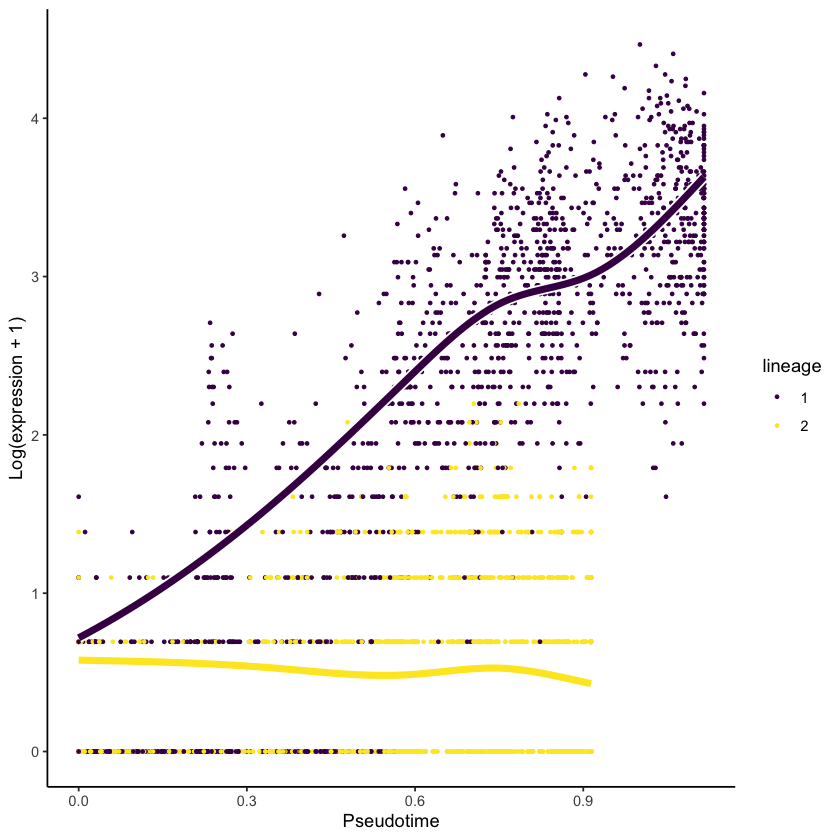

In [17]:
plotSmoothers(sce, counts, gene = rownames(patternRes)[oPat][4])


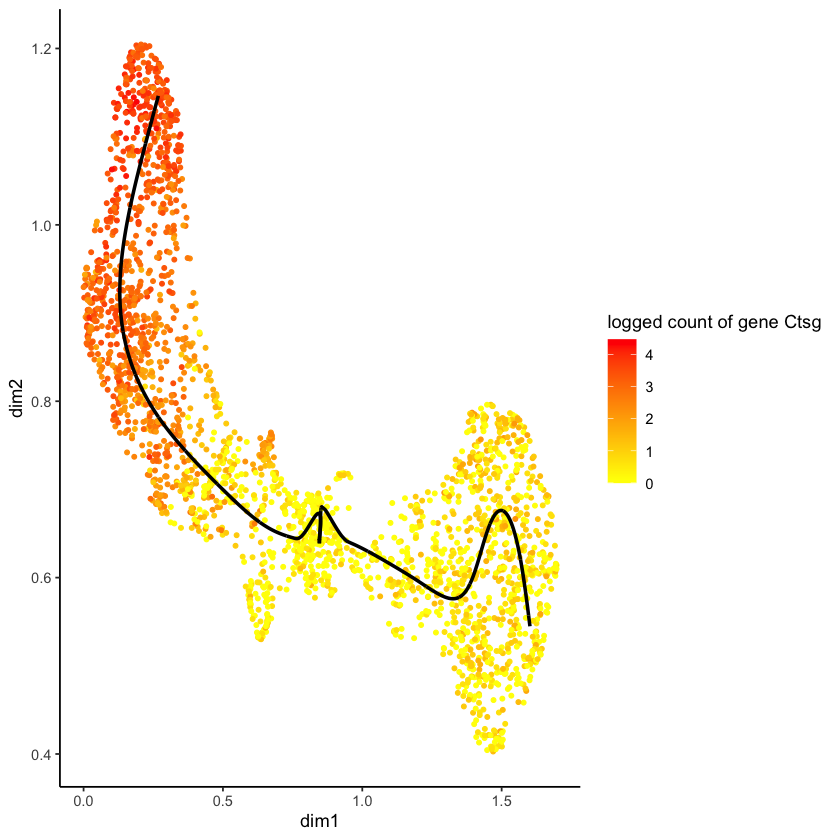

In [18]:
plotGeneCount(crv, counts, gene = rownames(patternRes)[oPat][4])

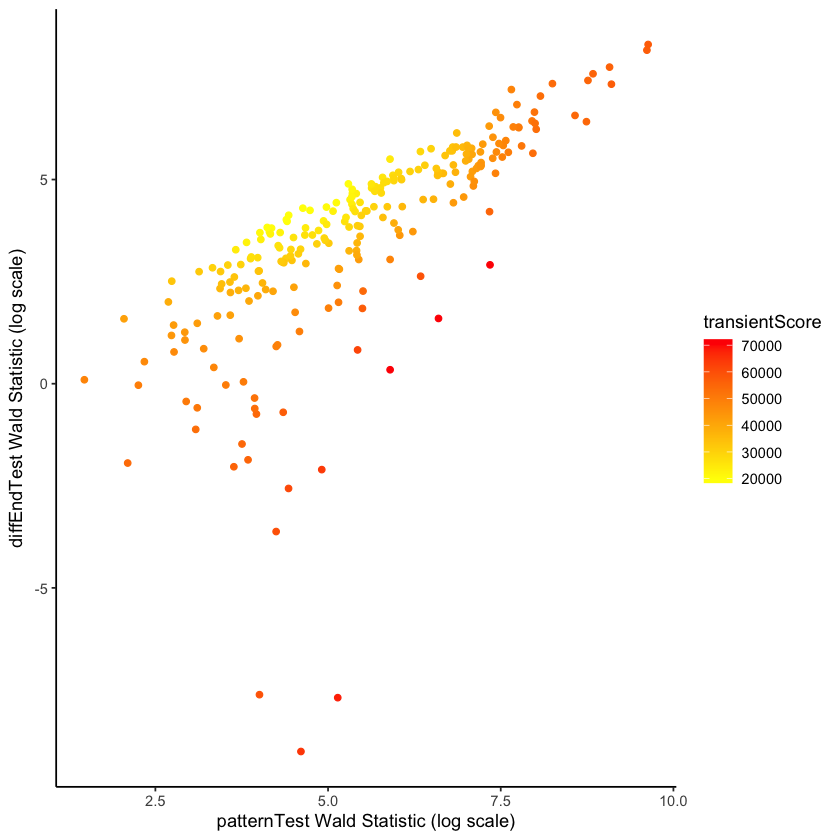

In [19]:
library(ggplot2)

patternRes$Gene <- rownames(patternRes)
patternRes$pattern <- patternRes$waldStat
patternRes <- patternRes[, c("Gene", "pattern")]

endRes$Gene <- rownames(endRes)
endRes$end <- endRes$waldStat
endRes <- endRes[, c("Gene", "end")]

compare <- merge(patternRes, endRes, by = "Gene", all = FALSE)
compare$transientScore <- 
  rank(-compare$end, ties.method = "min")^2 + rank(compare$pattern, ties.method = "random")^2

ggplot(compare, aes(x = log(pattern), y = log(end))) +
  geom_point(aes(col = transientScore)) +
  labs(x = "patternTest Wald Statistic (log scale)",
       y = "diffEndTest Wald Statistic (log scale)") +
  scale_color_continuous(low = "yellow", high = "red") +
  theme_classic()

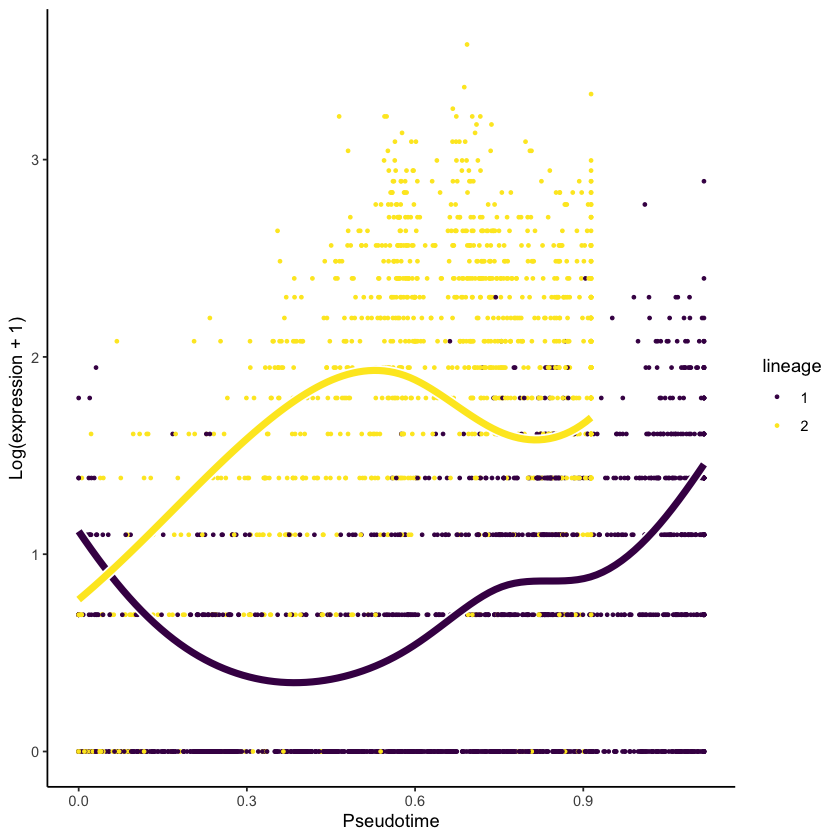

In [20]:
topTransient <- compare[which.max(compare$transientScore), "Gene"]
plotSmoothers(sce, counts, gene = topTransient)

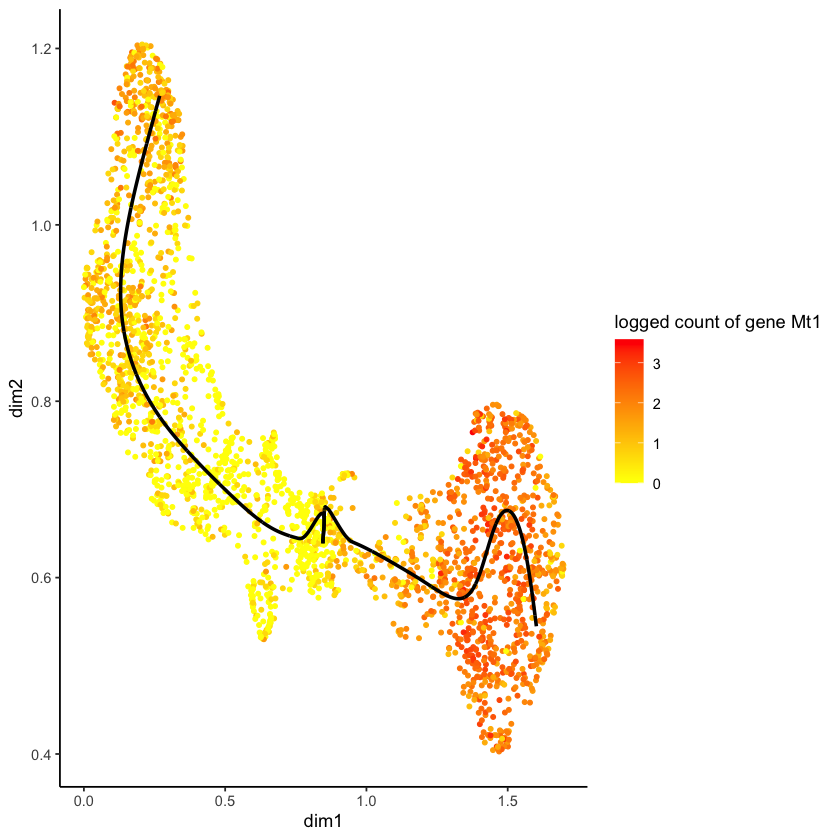

In [21]:
plotGeneCount(crv, counts, gene = topTransient)


In [22]:
head(
  compare[order(compare$transientScore, decreasing = TRUE), "Gene"],
  n = 5
)

[1] "Mt1"    "Irf8"   "Nedd4"  "Hint1"  "Eif4g1"

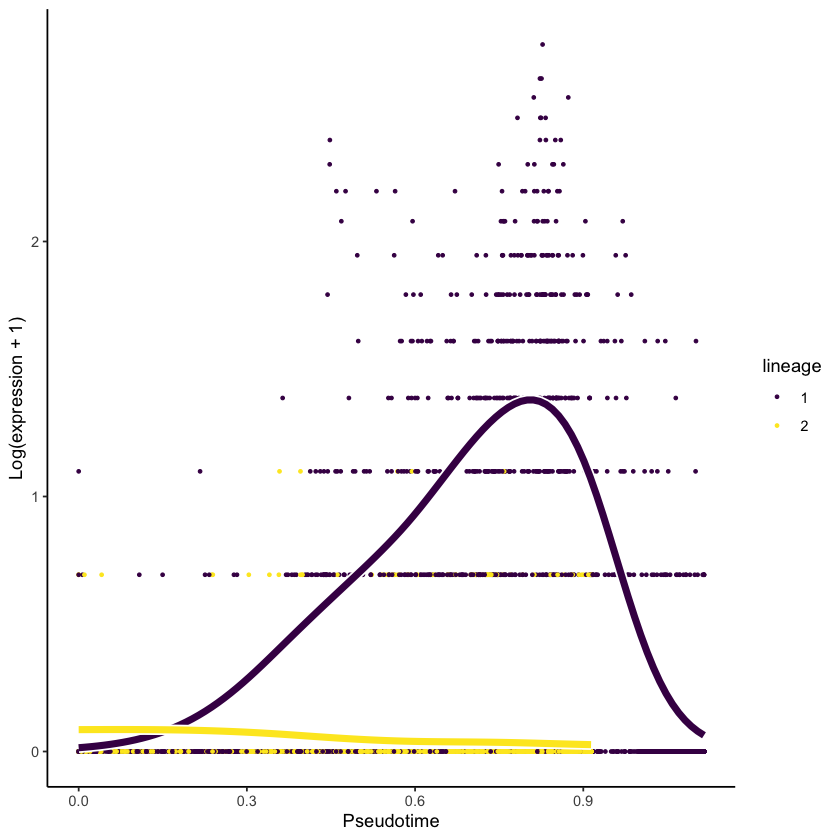

In [23]:
plotSmoothers(sce, counts, gene = "Irf8")

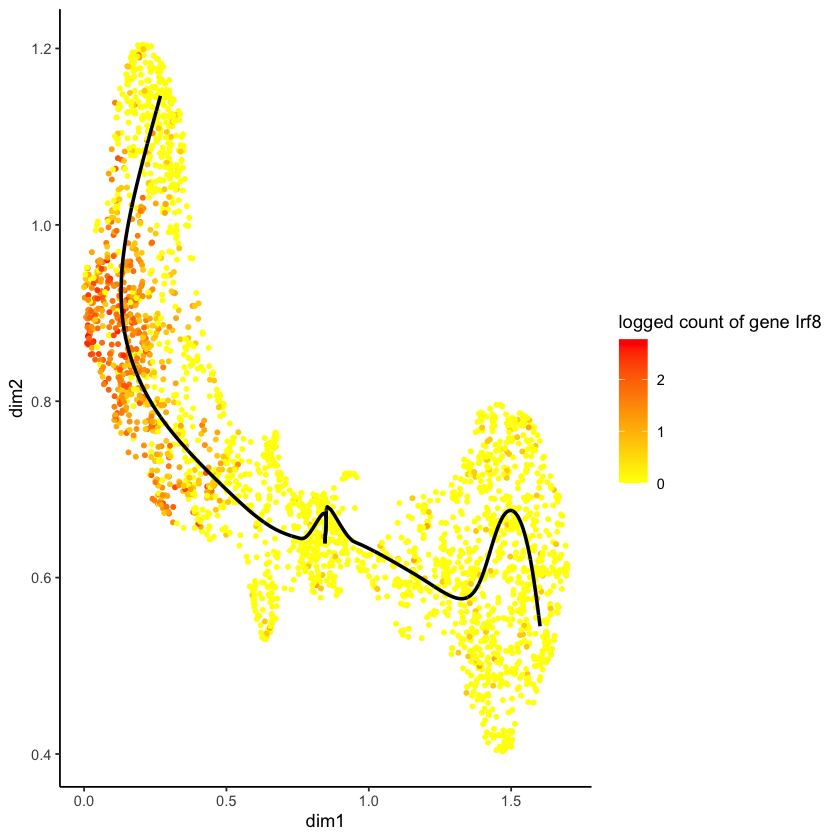

In [24]:
plotGeneCount(crv, counts, gene = "Irf8")

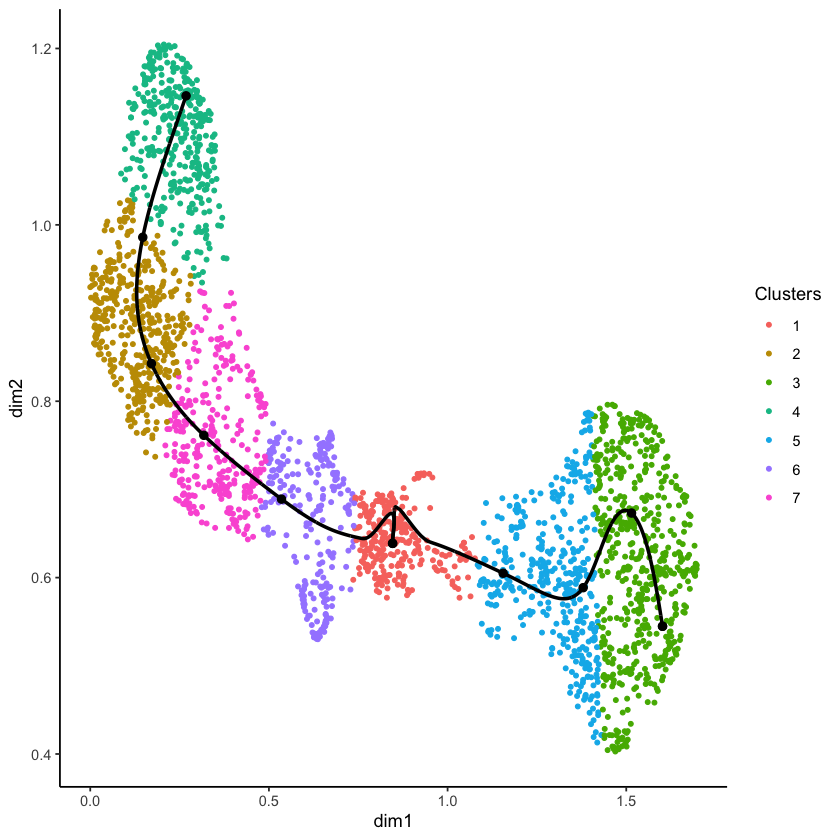

In [25]:
plotGeneCount(curve = crv, counts = counts,
              clusters = apply(slingClusterLabels(crv), 1, which.max),
              models = sce)

In [26]:
earlyDERes <- earlyDETest(sce, knots = c(1, 2))
oEarly <- order(earlyDERes$waldStat, decreasing = TRUE)
head(rownames(earlyDERes)[oEarly])

[1] "Car1"  "Car2"  "Klf1"  "Vim"   "Mt1"   "Ermap"

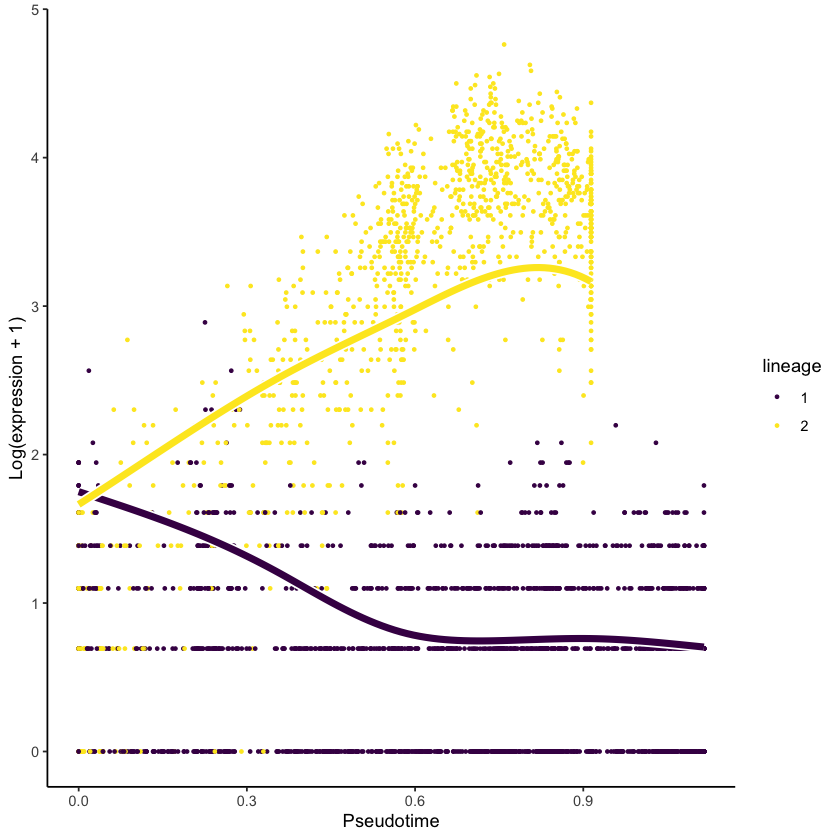

In [27]:
plotSmoothers(sce, counts, gene = rownames(earlyDERes)[oEarly][2])

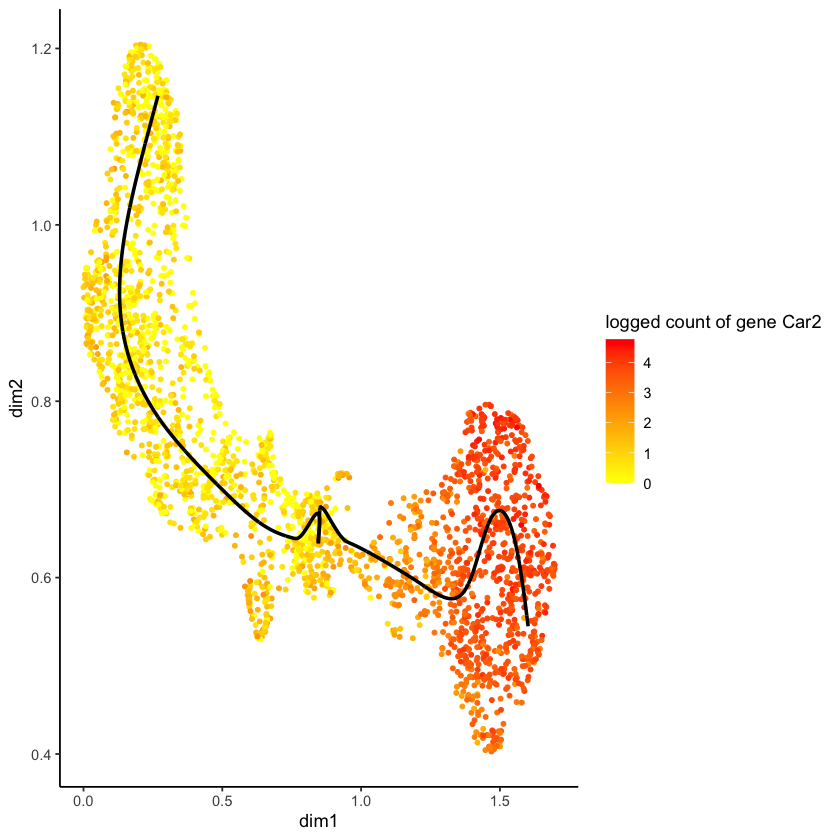

In [28]:
plotGeneCount(crv, counts, gene = rownames(earlyDERes)[oEarly][2])

In [29]:
# testing against fold change threshold of 2
start2 <- startVsEndTest(sce, l2fc = log2(2))
# testing against fold change threshold of 1.5
pat2 <- patternTest(sce, l2fc = log2(1.5))

In [30]:
yhat <- predictCells(models = sce, gene = "Irf8")

ysmooth <- predictSmooth(models = sce, gene = "Irf8", nPoints = 40)

In [32]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("clusterExperiment")

In [33]:
library(clusterExperiment)
nPointsClus <- 20
clusPat <- clusterExpressionPatterns(sce, nPoints = nPointsClus,
                                     genes = rownames(counts)[1:100])

Note: Not all of the methods requested in 'reduceMethod' have been calculated. Will calculate all the methods requested (any pre-existing values -- filtering statistics or dimensionality reductions -- with these names will be recalculated and overwritten): PCA.



36 parameter combinations, 36 use sequential method, 36 use subsampling method
Running Clustering on Parameter Combinations...
done.


Note: Merging will be done on ' makeConsensus ', with clustering index 1

Note: merging with these parameters did not result in any clusters being merged.



In [34]:
clusterLabels <- primaryCluster(clusPat$rsec)

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


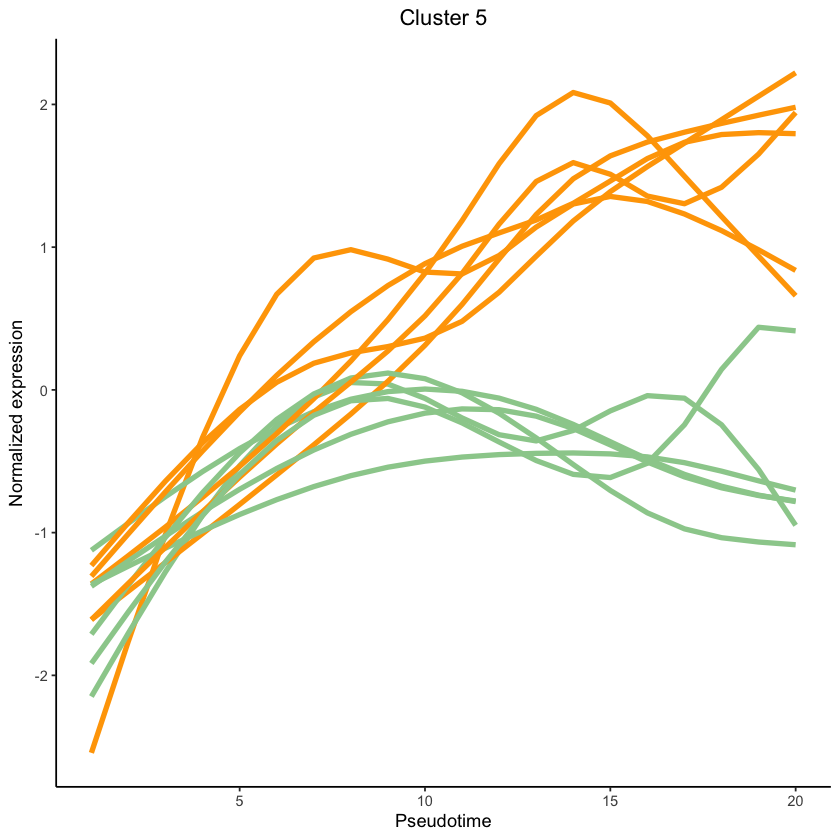

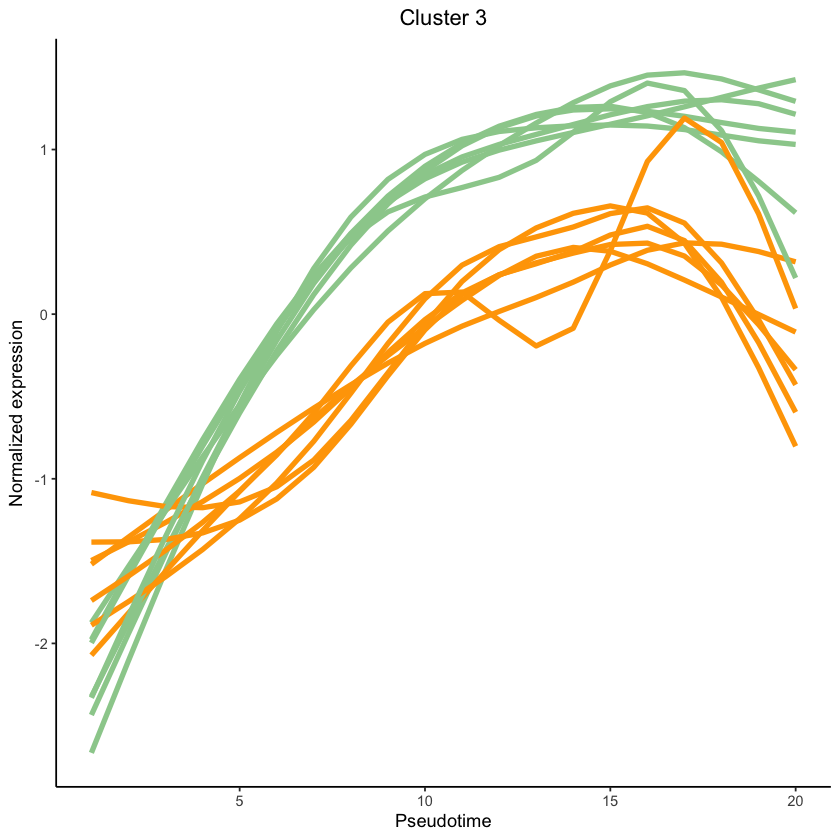

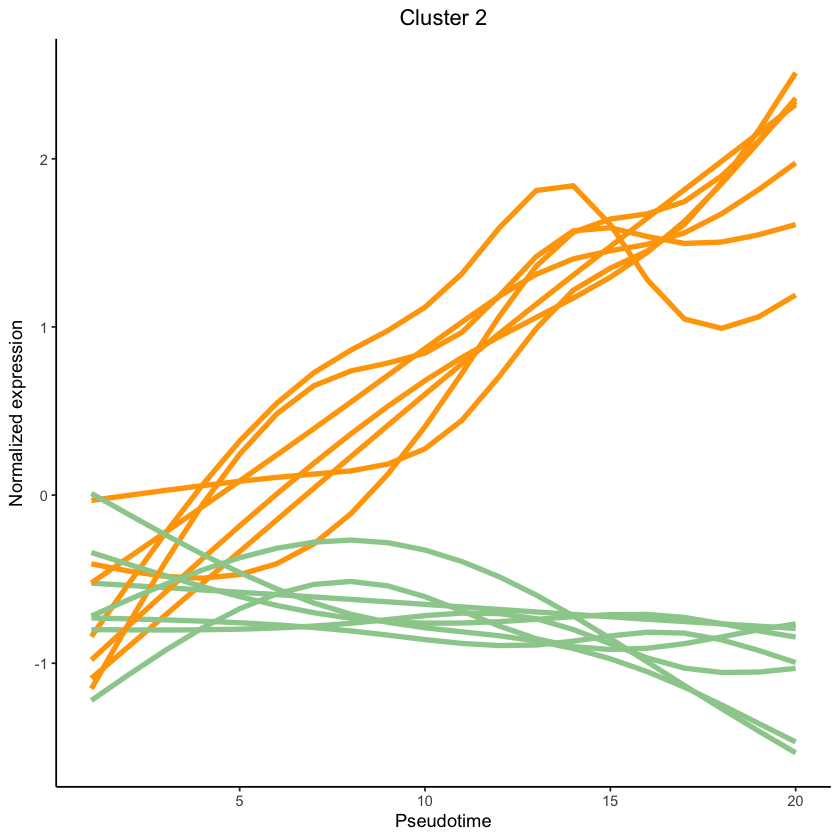

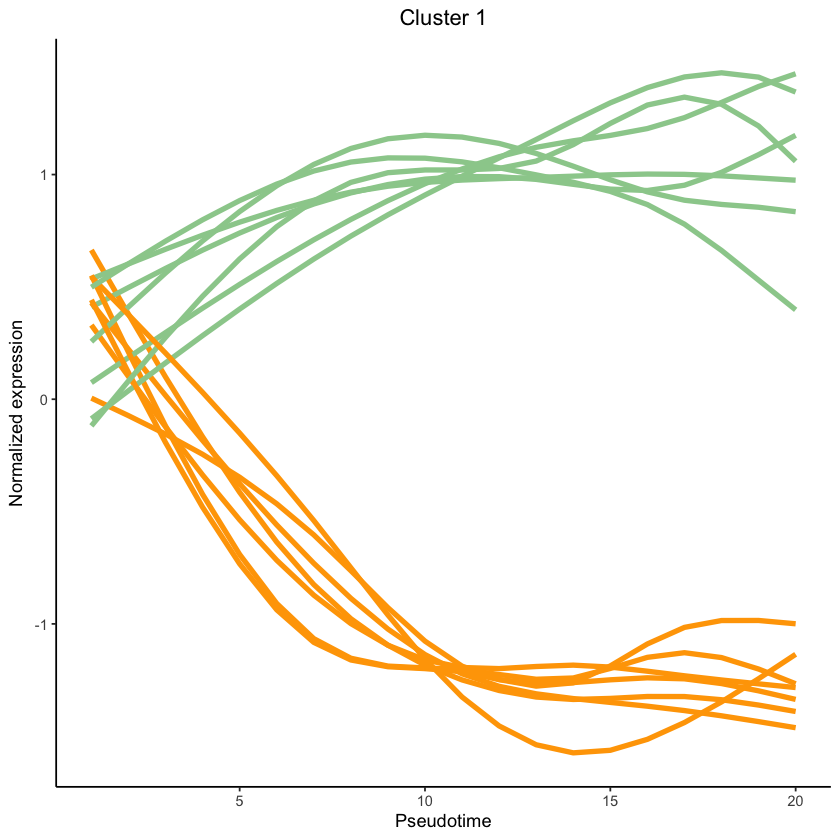

In [37]:
cUniq <- unique(clusterLabels)
cUniq <- cUniq[!cUniq == -1] # remove unclustered genes

for (xx in cUniq[1:4]) {
  cId <- which(clusterLabels == xx)
  p <- ggplot(data = data.frame(x = 1:nPointsClus,
                                y = rep(range(clusPat$yhatScaled[cId, ]),
                                        nPointsClus / 2)),
              aes(x = x, y = y)) +
    geom_point(alpha = 0) +
    labs(title = paste0("Cluster ", xx),  x = "Pseudotime", y = "Normalized expression") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))
  for (ii in 1:length(cId)) {
    geneId <- rownames(clusPat$yhatScaled)[cId[ii]]
    p <- p +
      geom_line(data = data.frame(x = rep(1:nPointsClus, 2),
                                  y = clusPat$yhatScaled[geneId, ],
                                  lineage = rep(0:1, each = nPointsClus)),
                aes(col = as.character(lineage), group = lineage), lwd = 1.5)
  }
  p <- p + guides(color = FALSE) +
    scale_color_manual(values = c("orange", "darkseagreen3"),
                       breaks = c("0", "1"))  
  print(p)
}